In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy import sparse, stats
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE, ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.combine import SMOTEENN
from typing import Counter

# Predicting Cancer Stages With DNA Type 4

## Extraction & Preprocessing

In [ ]:
# run this if on Google colab
# upload your folder to your google drive
from google.colab import drive
drive.mount('/content/drive')
#import os
#os.chdir("drive/My Drive/CA CE")

Mounted at /content/drive


In [ ]:
# make sure this notebook is in the same folder as the file
stage_df_1 = pd.read_excel("/content/drive/My Drive/Lung NEW.xlsx", sheet_name = 0)
stage_df_2 = pd.read_excel("/content/drive/My Drive/Lung NEW.xlsx", sheet_name = 1)
# rename case id to merge
stage_df_2.rename(columns = {"case_submitter_id": "Case ID"}, inplace = True)
# merge the df based on case id
stage_df = pd.merge(stage_df_1[["File ID", "File Name", "Case ID"]],
                    stage_df_2[["Case ID", "ajcc_pathologic_stage"]],
                    on = "Case ID")

In [ ]:
# update stage names
for i in range(stage_df.shape[0]):
    if not stage_df.loc[i, "ajcc_pathologic_stage"] == "Stage IV":
        if stage_df.loc[i, "ajcc_pathologic_stage"][:-1] == "Stage I":
            stage_df.loc[i, "ajcc_pathologic_stage"] = "Stage I"
        if stage_df.loc[i, "ajcc_pathologic_stage"][:-1] == "Stage II":
            stage_df.loc[i, "ajcc_pathologic_stage"] = "Stage II"
        if stage_df.loc[i, "ajcc_pathologic_stage"][:-1] == "Stage III":
            stage_df.loc[i, "ajcc_pathologic_stage"] = "Stage III"

In [ ]:
# extract the data from each folder
dfs = [
    pd.read_csv(f"/content/drive/My Drive/CA CE/{file_id}/{file_name}", sep="\t",
                header=1
    ).iloc[4:][["gene_name", "tpm_unstranded", "fpkm_unstranded", "fpkm_uq_unstranded",
                "gene_type"]]
     .query('gene_type == "protein_coding"')  # Filter for protein_coding gene_type
     [['gene_name', 'fpkm_unstranded']].set_index('gene_name').T.rename_axis(index=None)
     .reset_index(drop=True)
     .assign(ajcc_pathologic_stage = stage)
    for file_id, file_name, stage in stage_df[["File ID", "File Name", "ajcc_pathologic_stage"]].values
]
df = pd.concat(dfs)
df.shape

(992, 19963)

In [ ]:
# drop columns with all 0 values
df = df.drop(columns=df.columns[(df == 0).all()])
df.shape

(992, 19514)

In [ ]:
# drop missing y
mask = (df[["ajcc_pathologic_stage"]] == "'--").all(axis=1)
df = df[~mask]
df.reset_index(inplace=True, drop=True)
df.shape

(980, 19514)

In [ ]:
# test if normal is a good approximation
numerical_columns = df.drop(columns=['ajcc_pathologic_stage']).columns
count = 0
for column in numerical_columns:
    stat, p_value = stats.shapiro(df[column])
    alpha = 0.05
    if p_value > alpha:
        count += 1
# count how many columns are not normal
print(count)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


1


In [ ]:
# eliminate duplications
duplicated_columns = df.columns[df.columns.duplicated()].unique()
df = df.loc[:, ~df.columns.duplicated()]
df.shape

(980, 19509)

In [ ]:
# impute outliers
def impute_outliers(column):
    '''
    Detect outliers and impute those > Q3 + 1.5 * IQR with Q3 + 1.5 * IQR and
    those < Q1 - 1.5 * IQR with Q1 - 1.5 * IQR for a column in the data frame.
    '''
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column = column.apply(lambda x: lower_bound if x < lower_bound
                          else (upper_bound if x > upper_bound else x))
    return column

for col in df.columns[:-1]:
    df[col] = impute_outliers(df[col])

In [ ]:
# check for constant and drop
X_df = df.drop(columns=['ajcc_pathologic_stage'])
variances = X_df.var()
constant_columns = constant_columns = [col for col in X_df.columns if np.all(X_df[col] == X_df[col].iloc[0])]
df.drop(columns=constant_columns, inplace=True)
df.reset_index(drop=True)
print("Constant columns:", constant_columns)
print(len(constant_columns))

Constant columns: ['LGALS14', 'SPO11', 'WNT8A', 'MS4A12', 'PRLH', 'NOX3', 'FGF4', 'CFHR2', 'SLC13A1', 'DEFB127', 'SI', 'SLC17A6', 'MLN', 'AMELY', 'DDT', 'CST9L', 'SPINT3', 'F9', 'PPP1R2C', 'OPN1LW', 'MT4', 'GML', 'LGALS13', 'ZNRF4', 'CABP5', 'WDR83OS', 'NPVF', 'SPAM1', 'PAX4', 'NOBOX', 'PTGES3L-AARSD1', 'SMR3A', 'APOA4', 'APOC3', 'SCGB2A2', 'MYF5', 'FGF6', 'GYS2', 'SLC17A2', 'OR12D3', 'CDH9', 'GCG', 'NEU2', 'SMYD1', 'NPHS2', 'PRAMEF1', 'PRAMEF12', 'ZP4', 'CRYGD', 'TNP1', 'SPACA1', 'ZC2HC1B', 'CRHR1', 'IFNA6', 'IFNA8', 'MAGEB4', 'LYZL1', 'PRAMEF2', 'TAS2R8', 'TAS2R7', 'TAS2R9', 'GJA8', 'TBX22', 'MYOG', 'PRM2', 'ACTRT1', 'CCDC70', 'NEUROD4', 'SERPINA7', 'ESX1', 'ATXN3L', 'MC3R', 'SEMG2', 'ANKRD60', 'PSG8', 'CRISP1', 'TRIM51', 'AMELX', 'NPBWR2', 'BHLHE23', 'TGM3', 'GFRA4', 'DEFB129', 'C20orf173', 'GPR42', 'CSN1S1', 'HTN1', 'OR7A10', 'OR7C2', 'OR1E2', 'RFPL1', 'TAS2R16', 'VCY1B', 'VCY', 'CDY2B', 'GDF1', 'BMP15', 'OR11H1', 'HBZ', 'BPIFA3', 'DEFB118', 'CDX4', 'RHOXF2', 'FSHB', 'USP29', 'FTHL

In [ ]:
X = df.drop(columns=['ajcc_pathologic_stage'])
y = df['ajcc_pathologic_stage']

In [ ]:
# variance stablizing transformation (log scale)
X = X.apply(np.log1p)

In [ ]:
# detect multicolinearity
def calc_vif(X):
    '''
    Compute the variance inflation factor for every column in the input data
    '''
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

vifs = calc_vif(X)
high_vif_columns = vifs[vifs['VIF'] > 10]['variables']
print(len(high_vif_columns))

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


6506


In [ ]:
X = X.drop(columns = high_vif_columns)
X.shape

In [ ]:
# correct the labels
y = y.replace('ajcc_pathologic_stage_Stage I', 'Stage I')
y = y.replace('ajcc_pathologic_stage_Stage II', 'Stage II')
y = y.replace('ajcc_pathologic_stage_Stage III', 'Stage III')
y = y.replace('ajcc_pathologic_stage_Stage IV', 'Stage IV')

In [ ]:
# combine the labels
y = y.replace('Stage I', 'Stage I/II')
y = y.replace('Stage II', 'Stage I/II')
y = y.replace('Stage III', 'Stage III/IV')
y = y.replace('Stage IV', 'Stage III/IV')

In [ ]:
# encode y
encoder = OrdinalEncoder()
y = y.values.reshape(-1, 1)
y_encoded = encoder.fit_transform(y)

In [ ]:
# note what stage is mapped to what index
categories = encoder.categories_[0]
for index, category in enumerate(categories):
    print(f"Category '{category}' is mapped to {index}")

Category 'Stage I/II' is mapped to 0
Category 'Stage III/IV' is mapped to 1


In [ ]:
y_1 = y_encoded.flatten()

In [ ]:
# split training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y_1, shuffle=True,
                                                    test_size=0.1, random_state=42,
                                                    stratify=y)

In [ ]:
X_train.shape

(882, 18188)

In [ ]:
# feature selection via p-value
train_df = X_train.copy()
train_df['ajcc_pathologic_stage'] = y_train
significant_columns = []
for column in train_df.columns:
    if column != 'ajcc_pathologic_stage':
        data_stage_12 = train_df[train_df['ajcc_pathologic_stage'] == 0][column]
        data_stage_34 = train_df[train_df['ajcc_pathologic_stage'] == 1][column]
        fvalue, pvalue = stats.f_oneway(data_stage_12, data_stage_34)
        if pvalue < 0.05:
            significant_columns.append(column)
X_train = X_train[significant_columns]
X_test = X_test[significant_columns]

In [ ]:
X_train.shape

(882, 3588)

In [ ]:
# standardize the data
feature_names = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = feature_names)
X_test = scaler.transform(X_test)

In [ ]:
# oversample the data
counter = Counter(y_encoded.ravel())
print('Before', counter)
ada = ADASYN(sampling_strategy='all', random_state=130)
X_train, y_train = ada.fit_resample(X_train, y_train)
counter = Counter(y_train.ravel())
print('After', counter)

Before Counter({0.0: 789, 1.0: 191})
After Counter({0.0: 710, 1.0: 687})


## Model Training

In [ ]:
# hyperparameter tuning for LASSO
params = {"C": [0.01, 0.1, 1, 5, 10, 50, 100]}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lasso = LogisticRegression(penalty = "l1", solver = 'liblinear', max_iter=1000)
lasso_cv = RandomizedSearchCV(lasso, params, cv=kf, scoring="accuracy", n_jobs=-1)
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params {'C': 1}


In [ ]:
# feature selection with regularization (lasso)
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty = "l1",
                                                         solver = 'liblinear',
                                                         max_iter=1000,
                                                         C = lasso_cv.best_params_['C']),
                                      max_features = 40)
embeded_lr_selector_2 = SelectFromModel(LogisticRegression(penalty = "l1",
                                                          solver = 'liblinear',
                                                          max_iter=1000,
                                                          C = lasso_cv.best_params_['C']),
                                      max_features = 100)
embeded_lr_selector.fit(X_train, y_train)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature_names = [feature_names[i] for i, flag in enumerate(embeded_lr_support) if flag]
print(embeded_lr_feature_names)

['HOXA11', 'MAMLD1', 'SERPINB3', 'TBC1D25', 'PYGM', 'DLL3', 'MAPK1', 'C5', 'SERP1', 'SNAI1', 'IGFLR1', 'AANAT', 'AOC2', 'SOX3', 'C6orf52', 'RBMS3', 'SPATA16', 'ATP5F1A', 'G6PC2', 'C12orf43', 'SLC30A8', 'RAB4B', 'ZNF778', 'MRGPRD', 'PPP1R14B', 'SLITRK1', 'ZFP42', 'MAB21L2', 'SYNM', 'SNN', 'AP3M1', 'LRCH3', 'GLDN', 'ADH4', 'SERPINE3', 'TAS2R43', 'SMIM11B', 'PKD1L3', 'MRPL45', 'TEX13C']


In [ ]:
# logistic regression
# param_grid = {
#     'classification__C': [0.01, 0.1, 1, 10, 50, 100],
#     'classification__penalty': ['l2', None],
#     'classification__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#     'classification__max_iter': [200, 300, 500, 1000],
# }
# logreg = LogisticRegression()
# pipeline_lr = Pipeline([
#     ('feature_selection', embeded_lr_selector_2),
#     ('classification', logreg)
# ])
# logreg_cv = GridSearchCV(pipeline_lr, param_grid, cv = kf, scoring="f1")
# logreg_cv.fit(X_train, y_train)
# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
# print("Best score is {}".format(logreg_cv.best_score_))

In [ ]:
# decision tree
param_grid = {
    'classification__max_depth': [3, 5, 7, 10, 15, 20],
    'classification__min_samples_split': [2, 5, 10, 20, 50],
    'classification__min_samples_leaf': [2, 4, 6, 8],
    'classification__criterion': ['gini', 'entropy'],
    'classification__max_features': ['sqrt', 'log2'],
    'classification__class_weight': ['balanced', None],
}
dtree = DecisionTreeClassifier(random_state=0, splitter='best')
pipeline_dt = Pipeline([
    ('feature_selection', embeded_lr_selector_2),
    ('classification', dtree)
])
dtree_cv = RandomizedSearchCV(pipeline_dt, param_grid, cv = kf, scoring="accuracy")
dtree_cv.fit(X_train, y_train)
print("Tuned Decision Tree Parameters: {}".format(dtree_cv.best_params_))
print("Best score is {}".format(dtree_cv.best_score_))

Tuned Decision Tree Parameters: {'classification__min_samples_split': 5, 'classification__min_samples_leaf': 8, 'classification__max_features': 'sqrt', 'classification__max_depth': 20, 'classification__criterion': 'entropy', 'classification__class_weight': None}
Best score is 0.7316495375128469


In [ ]:
# nearest neighbor
param_grid = {
    'classification__n_neighbors': [3, 5, 7, 10, 15],
    'classification__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classification__weights': ['uniform', 'distance'],
    'classification__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classification__leaf_size': [10, 20, 30, 40, 50],
}
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([
    ('feature_selection', embeded_lr_selector_2),
    ('classification', knn)
])
knn_cv = RandomizedSearchCV(pipeline_knn, param_grid, cv=kf, scoring="accuracy")
knn_cv.fit(X_train, y_train)
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'classification__weights': 'distance', 'classification__n_neighbors': 3, 'classification__metric': 'manhattan', 'classification__leaf_size': 40, 'classification__algorithm': 'kd_tree'}
Best score is 0.6514594039054471


In [212]:
# random forest
param_grid = {
    'classification__n_estimators': [25, 50, 100, 200],
    'classification__max_depth': [3, 5, 7, 10],
    'classification__min_samples_split': [2, 5, 10, 20],
    'classification__min_samples_leaf': [2, 4, 6, 8, 10],
    'classification__max_features': ['sqrt', 'log2', 100],
    'classification__bootstrap': [True, False],
    'classification__criterion': ['gini', 'entropy'],
    'classification__class_weight': ['balanced', 'balanced_subsample']
}
rf = RandomForestClassifier()
pipeline_rf = Pipeline([
    ('feature_selection', embeded_lr_selector_2),
    ('classification', rf)
])
rf_cv = RandomizedSearchCV(pipeline_rf, param_grid, cv = kf, scoring="accuracy",
                           random_state=42)
rf_cv.fit(X_train, y_train)
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Random Forest Parameters: {'classification__n_estimators': 100, 'classification__min_samples_split': 5, 'classification__min_samples_leaf': 2, 'classification__max_features': 'sqrt', 'classification__max_depth': 10, 'classification__criterion': 'entropy', 'classification__class_weight': 'balanced', 'classification__bootstrap': True}
Best score is 0.9097687564234327


In [211]:
# gradient boosting
param_grid = {
    'classification__n_estimators': [25, 50, 100],
    'classification__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classification__max_depth': [3, 4, 5],
    'classification__min_child_weight': [3, 5, 7],
    'classification__gamma': [0, 0.1, 0.2, 0.5, 1],
    'classification__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classification__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'classification__reg_alpha': [0.1, 0.5, 1],
    'classification__reg_lambda': [0.1, 0.3, 0.5, 0.7, 1]
}
# X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# xgb = XGBClassifier(tree_method="hist", random_state=0,
#                     objective="binary:logistic", early_stopping_rounds=10,
#                     eval_set=[(X_val, y_val)], verbose=True)
xgb = XGBClassifier(tree_method="hist", random_state=0,
                    objective="binary:logistic")
pipeline_xgb = Pipeline([
    ('feature_selection', embeded_lr_selector_2),
    ('classification', xgb)
])
xgb_cv = RandomizedSearchCV(pipeline_xgb, param_grid, cv=kf,
                            scoring="accuracy", random_state=42)
xgb_cv.fit(X_train, y_train)
print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned XGBoost Parameters: {'classification__subsample': 0.7, 'classification__reg_lambda': 0.3, 'classification__reg_alpha': 1, 'classification__n_estimators': 100, 'classification__min_child_weight': 7, 'classification__max_depth': 4, 'classification__learning_rate': 0.1, 'classification__gamma': 0.1, 'classification__colsample_bytree': 1.0}
Best score is 0.881906474820144


## Model Validation

In [249]:
model = rf_cv.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


0.826530612244898

In [250]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


0.7021985343104598

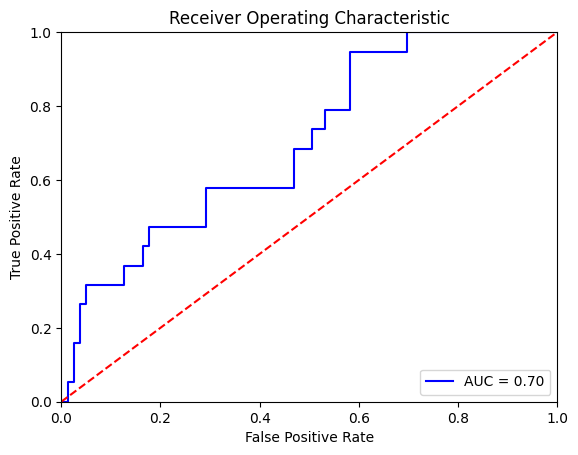

In [251]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


<Axes: >

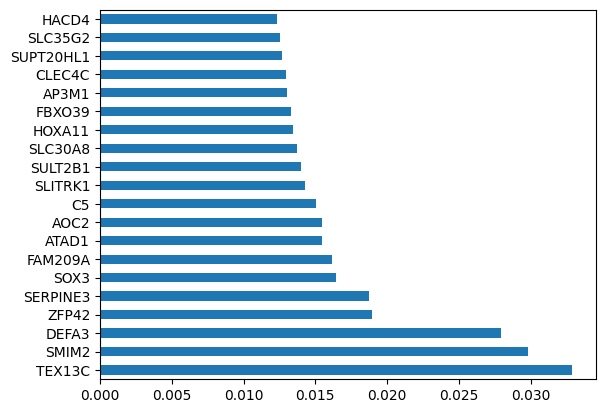

In [252]:
embeded_lr_selector_2.fit(X_train, y_train)
embeded_lr_support2 = embeded_lr_selector_2.get_support()
embeded_lr_feature_names2 = [feature_names[i] for i, flag in enumerate(embeded_lr_support2) if flag]
X_train_2 = embeded_lr_selector_2.transform(X_train)
X_test_2 = embeded_lr_selector_2.transform(X_test)
model2 = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 2,
                                max_features = 'sqrt', max_depth = 10, criterion = 'entropy',
                                class_weight = 'balanced', bootstrap = True)
model2.fit(X_train_2, y_train)
y_pred_2 = model2.predict(X_test_2)
feat_importances = pd.Series(model2.feature_importances_, index=embeded_lr_feature_names2)
feat_importances.nlargest(20).plot(kind='barh')